# Manhattan Property Market Report                                               

## Objective:
- Derive actionable insights from the dataset provided

## Structure
- Feature Engineering
- Exploratory Data Analysis
- Modelling
- Executive Summary

In [1]:
import pandas as pd
from pandas import Grouper
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import os 
from scipy.stats import skew, norm 
from numpy import percentile
from scipy import stats 
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
from sklearn.metrics import r2_score,mean_squared_error,scorer
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
## Load and read 'xlsx' file 
path=os.getcwd()
df=pd.read_excel(os.path.join(path+'/data'+'/rollingsales_manhattan.xlsx'),header=4)

## Feature Engineering
- Missing Values, Label Encoding
- Outliers Handling
- Quartile Cut Continuous Numerical Features
- Create Training & Test Data


In [3]:
## Rename columns to lower case and replace ' ' with '_' etc.
df.rename(columns=lambda x: x.lower().replace('\n',' ').replace(' ','_').replace('-','_'),inplace=True)
print('Shape of DF is: {}'.format(df.shape))

Shape of DF is: (27395, 21)


### Missing Values, Convert Dtype, Label Encoding

In [4]:
## Create missing value dataframe 
total_missing=df.isnull().sum().sort_values(ascending=False)
percentage=(df.isnull().sum()/(df.isnull().count())).sort_values(ascending=False)
missing_data=pd.concat([total_missing,percentage],keys=['total_missing','percentage'],axis=1).head(6)
print(missing_data)

## Drop column with % of missing value more than the threshold of 60%, which is ease_ment(100% missing value)
df=df.drop(missing_data[missing_data.percentage>0.6].index,1)
## Other missing values: apart_ment_number(50%)
df.loc[:,'apart_ment_number']=df.loc[:,'apart_ment_number'].fillna('Unknown')

## building_class_category(12% missing), so fillna with its mode as it won't dramatically affect our data  
## same for tax_class_at_present & building_class_at_present(0.5%),neighborhood(0.06%)
df.loc[:,'building_class_category']=df.loc[:,'building_class_category'].fillna('13  CONDOS - ELEVATOR APARTMENTS')
df.loc[:,'tax_class_at_present']=df.loc[:,'tax_class_at_present'].fillna(2)
df.loc[:,'building_class_at_present']=df.loc[:,'building_class_at_present'].fillna('R4')
df.loc[:,'neighborhood']=df.loc[:,'neighborhood'].fillna('MIDTOWN WEST')

## Drop collinear features, such as 'residential_units'vs 'total_units','land_square_feet'vs 'gross_square_feet'
df=df.drop(['land_square_feet','residential_units'],axis=1)

## Convert data to right dtypes:
df['sale_price']=df.sale_price.astype('str').str.replace('$','').str.replace(',','').astype(int)
df['sale_date']=df.sale_date.apply(lambda x: x.strftime('%Y-%m'))
df['borough']=df.borough.astype('str')
df['zip_code']=df.zip_code.astype('str')

## Label encoding
df.block.replace({1027:'block1027',1009:'block1009',1006:'block1006'},inplace=True)
df.loc[-df.block.isin(['block1027','block1009','block1006']),'block']='rest_block'
df.tax_class_at_time_of_sale.replace({2:'Class2',4:'Class4',1:'Class1'},inplace=True)
df.tax_class_at_present.replace({'1C':1,'1A':1,'2B':'2A/B','2A':'2A/B'},inplace=True)
# df['apart_ment_number']=np.where(df.apart_ment_number.str.contains('TIME'),1,0)
df.apart_ment_number.replace({'TIMES':1,'Unknown':0},inplace=True)
df.loc[-df.apart_ment_number.isin([0,1]),'apart_ment_number']=2
df.loc[-df.building_class_at_time_of_sale.isin(['R4','D4','RH','H2','R9','R5','C6']),'building_class_at_time_of_sale']='rest_class'
df.building_class_category.replace(
{'13  CONDOS - ELEVATOR APARTMENTS':1,
 '10  COOPS - ELEVATOR APARTMENTS':2,'25  LUXURY HOTELS':3,
 '17  CONDOPS':4,'07  RENTALS - WALKUP APARTMENT':5,
'28  COMMERCIAL CONDOS':6,'09  COOPS - WALKUP APARTMENTS':7 },inplace=True)
df.loc[-df.building_class_category.isin([1,2,3,4,5,6,7]),'building_class_category']=8

                           total_missing  percentage
ease_ment                          27395    1.000000
apart_ment_number                  14570    0.531849
building_class_category             3454    0.126081
tax_class_at_present                 143    0.005220
building_class_at_present            143    0.005220
neighborhood                          17    0.000621


### Outliers

[Text(0.5, 1.0, 'Sale Price vs Year Built')]

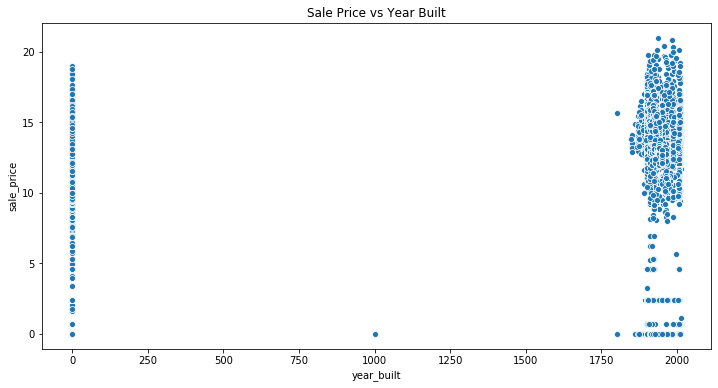

In [13]:
f,ax=plt.subplots(figsize=(12,6))
sns.scatterplot(x=df.year_built,y=np.log1p(df.sale_price)).set(title='Sale Price vs Year Built')

In [5]:
## Outliers for Sale_Price, total of 2674 
q1=df.sale_price.quantile(0.25)
q3=df.sale_price.quantile(0.75)
iqr=q3-q1
cut_off=1.5*iqr
lower,upper=q1-cut_off,q3+cut_off
outliers=[x for x in df.sale_price if x <lower or x>upper]
pd.Series(outliers).count()
## Create custom binary column to capture outliers instead of deleting them
df['outlier_sale_price']=np.where(df.sale_price.isin(outliers),1,0)
## Outlier of year built 1000, likely data entry error, so replace it with valid non zero year_built mode 2007 
df.loc[df.year_built==1000,'year_built']=2007
## Outliers with unknown year_built is treated as 0,we use price_band and fill zeros with each band's median year_built
df.loc[(df.sale_price>-0.001)&(df.sale_price<=28446.667)&(df.year_built==0),'year_built']=int(df.loc[(df.sale_price>-0.001)&(df.sale_price<=28446.667),'year_built'].median())
df.loc[(df.sale_price>28446.667)&(df.sale_price<=820000.0)&(df.year_built==0),'year_built']=int(df.loc[(df.sale_price>28446.667)&(df.sale_price<=820000.0),'year_built'].median())
df.loc[(df.sale_price>820000.0)&(df.sale_price<=1307965050.0)&(df.year_built==0),'year_built']=int(df.loc[(df.sale_price>820000.0)&(df.sale_price<=1307965050.0),'year_built'].median())

### Label encoding, quartile cut continuous numerical features & turn them to ordinal

In [6]:
df_new=df.copy()

## Label encode neighborhood 
le=LabelEncoder()
df_new['neighborhood']=le.fit_transform(df_new.neighborhood)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

## Quartile cut or transform continuous numerical features to bands and turn them to ordinal

## lot : [(0.999, 37.0] < (37.0, 1007.0] < (1007.0, 1233.0] < (1233.0, 9117.0]]
lot_band=pd.qcut(df.lot,4)
df_new.loc[(df_new.lot>0.999)&(df.lot>=37),'lot']=0
df_new.loc[(df_new.lot>37)&(df_new.lot<=1007),'lot']=1
df_new.loc[(df_new.lot>1007) &(df_new.lot<=1233),'lot']=2
df_new.loc[(df_new.lot>1233)&(df_new.lot<=9117),'lot']=3
## Turn total_units to [0,1,2,3+]
df_new.loc[-df_new.total_units.isin([-0,1,2]),'total_units']=3

df_new['gross_square_feet']=np.where(df_new.gross_square_feet !=0,1,0)

## Sale_Price: [(-0.001, 28446.667] < (28446.667, 820000.0] < (820000.0, 1307965050.0]]
price_band=pd.qcut(df_new.sale_price,3)
df_new.loc[(df_new.sale_price>-0.001)&(df_new.sale_price<=28446.667),'sale_price']=0
df_new.loc[(df_new.sale_price>28446.667)&(df_new.sale_price<=820000.0),'sale_price']=1
df_new.loc[(df_new.sale_price>820000.0)&(df_new.sale_price<=1307965050.0),'sale_price']=2
## Year_Built:[(1799.999, 1910.0] < (1910.0, 1930.0] < (1930.0, 1973.0] < (1973.0, 2013.0]]
year_band=pd.qcut(df_new.year_built,4)
df_new.loc[(df_new.year_built>1799.999)&(df_new.year_built<=1910.0),'year_built']=0
df_new.loc[(df_new.year_built>1910.0)&(df_new.year_built<=1930.0),'year_built']=1
df_new.loc[(df_new.year_built>1930.0)&(df_new.year_built<=1973.0),'year_built']=2
df_new.loc[(df_new.year_built>1973.0)&(df_new.year_built<=2013.0),'year_built']=3

### Create Training & Test Data

In [7]:
## Define label_encoding function to encode all the cat_features
def encode_features(train_cat):
    features=cat_features
    
    for feature in features:
        le=LabelEncoder()
        train_cat[feature]=le.fit_transform(train_cat[feature])
    return train_cat

In [9]:
##Split df to categorical and numerical features  
cat_features=df_new.select_dtypes(include=['object']).columns
num_features=df_new.select_dtypes(exclude=['object']).columns
num_features=num_features.drop(['neighborhood','lot','apart_ment_number','commercial_units','year_built','sale_price','outlier_sale_price'])
cat_features=cat_features.drop(['borough','address'])
## Create training data
train_cat=df_new[cat_features]
train_num=df_new[num_features]
train_cat['tax_class_at_present']=train_cat['tax_class_at_present'].astype('str')
train_cat=encode_features(train_cat)
train=pd.concat([train_cat,train_num],axis=1)
y=df_new.sale_price.values
y_logistic=df_new.outlier_sale_price.values

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Exploratory Data Analysis
 - Neighborhood Analysis
 - Market Analysis

[Text(0.5, 1, 'Correlation Heatmap')]

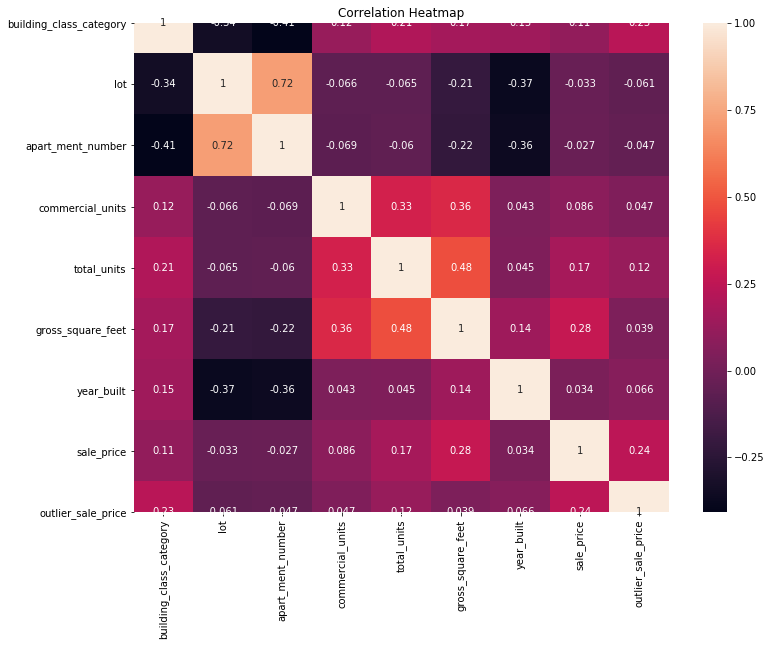

In [36]:
f,ax=plt.subplots(figsize=(12,9))
sns.heatmap(df.corr(),annot=True).set(title='Correlation Heatmap')

In [390]:
## Display neighborhood mapping for later analysis
le_name_mapping

{'ALPHABET CITY': 0,
 'CHELSEA': 1,
 'CHINATOWN': 2,
 'CIVIC CENTER': 3,
 'CLINTON': 4,
 'EAST VILLAGE': 5,
 'FASHION': 6,
 'FINANCIAL': 7,
 'FLATIRON': 8,
 'GRAMERCY': 9,
 'GREENWICH VILLAGE-CENTRAL': 10,
 'GREENWICH VILLAGE-WEST': 11,
 'HARLEM-CENTRAL': 12,
 'HARLEM-EAST': 13,
 'HARLEM-UPPER': 14,
 'HARLEM-WEST': 15,
 'INWOOD': 16,
 'JAVITS CENTER': 17,
 'KIPS BAY': 18,
 'LITTLE ITALY': 19,
 'LOWER EAST SIDE': 20,
 'MANHATTAN VALLEY': 21,
 'MANHATTAN-UNKNOWN': 22,
 'MIDTOWN CBD': 23,
 'MIDTOWN EAST': 24,
 'MIDTOWN WEST': 25,
 'MORNINGSIDE HEIGHTS': 26,
 'MURRAY HILL': 27,
 'SOHO': 28,
 'SOUTHBRIDGE': 29,
 'TRIBECA': 30,
 'UPPER EAST SIDE (59-79)': 31,
 'UPPER EAST SIDE (79-96)': 32,
 'UPPER EAST SIDE (96-110)': 33,
 'UPPER WEST SIDE (59-79)': 34,
 'UPPER WEST SIDE (79-96)': 35,
 'UPPER WEST SIDE (96-116)': 36,
 'WASHINGTON HEIGHTS LOWER': 37,
 'WASHINGTON HEIGHTS UPPER': 38}

### Neighborhood Analysis

In [15]:
pd.crosstab(df_new.neighborhood,df_new.building_class_category).sort_values(by=[1],ascending=False).head(10)

building_class_category,1,2,3,4,6,7,8
neighborhood,,,,,,,
25,3743,200,1636,16,603,10,73
34,1007,588,0,276,38,46,98
31,942,1135,0,183,7,58,244
32,594,1082,0,25,109,107,200
30,542,44,0,6,8,2,77
24,455,791,1,35,5,4,66
1,454,218,0,86,21,84,165
7,453,18,0,2,5,0,25
35,356,524,0,47,3,66,137


- Neighborhoods with the most elevator apartments are MidtownWest and UpperWestAndEastSide,followed by Tribeca and Chelsea,MidtownEast and Financial.Only MidtownWest has LuxuryHotel and most CommercialCondos.

In [8]:
## What are the top 10 neighborhood and what do their sale_price look like?
top10_neighbor=df.groupby('neighborhood').count()['borough'].sort_values(ascending=False).head(10)
top10_neighbor_df=pd.DataFrame({'Neighbor':top10_neighbor.index,'Count':top10_neighbor.values})
mask=df.neighborhood.isin(top10_neighbor.index)
price=df[mask][['neighborhood','sale_price']]
year=df[mask][['neighborhood','year_built']]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

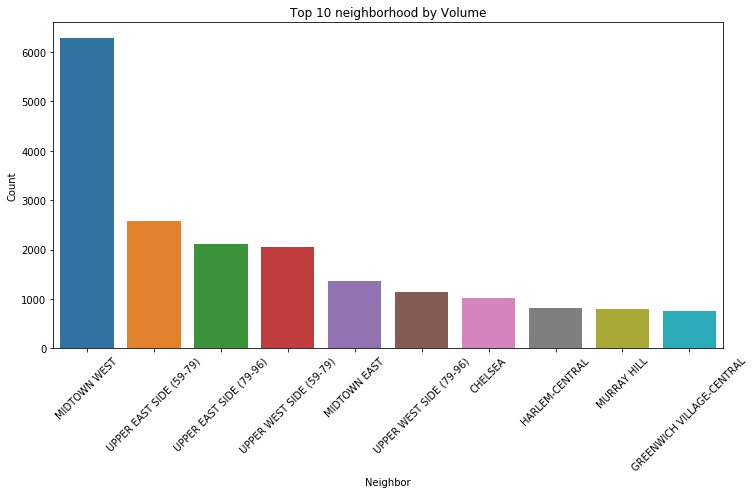

<Figure size 432x288 with 0 Axes>

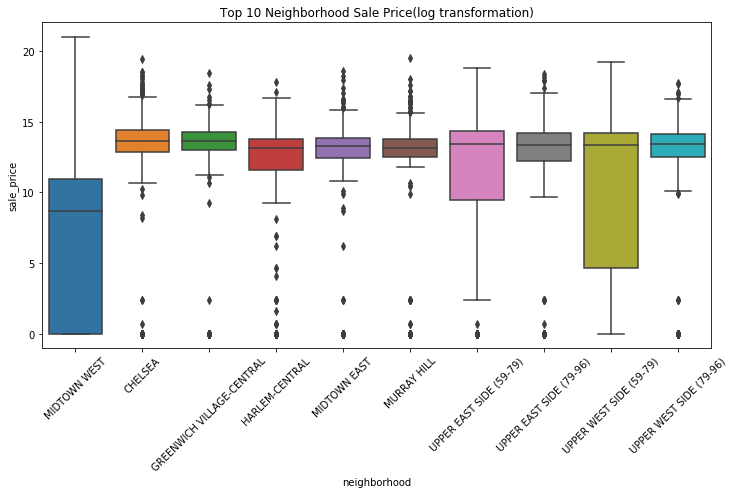

In [13]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
plt.figure(1).show()
sns.barplot(x='Neighbor',y='Count',data=top10_neighbor_df).set(title='Top 10 neighborhood by Volume')
plt.figure(2).show()
plt.figure(figsize=(12,6))
sns.boxplot(x=price['neighborhood'],y=np.log1p(price['sale_price'])).set(title='Top 10 Neighborhood Sale Price(log transformation)')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

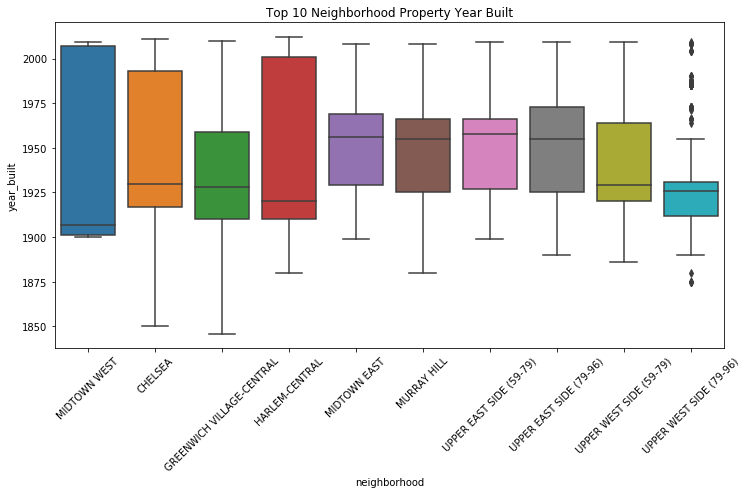

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(x=year.neighborhood,y=year.year_built).set(title='Top 10 Neighborhood Property Year Built')
plt.xticks(rotation=45)

- Top 10 neighborhoods are Midtown West/East, Upper East/West Side,Chelsea, Harlem-Central etc. Midtown West is the most dominant commercial neighborhood with 64% not for sale properties mainly Luxury Hotels,Condos-Elevator Apartments and Commercial Condos, hence lots of outlier luxury apartments.The rest neighborhoods are more residential and have similar price range. For both UpperEastOrWestSide(59-79),there is a huge lower price range properties bucause majority of the properties are not for sale(sale_price=0) which pushes down its price distribution.

- MidtownWest has the most old buildings and the most newest buildings as well, which explains its lower price range properties. Chelsea and Harlem-Central also have 2nd most old buildings,which explains its lower price range and its newly built properties help push up its property price. UpperSide generally has more modern buildings, which enables it to maintain middle upper maket property price.

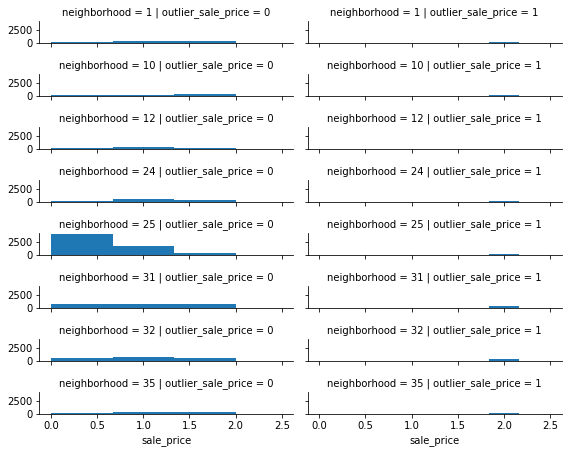

In [327]:
## What are the most affluent neighborhood? 
g=sns.FacetGrid(df_new[df_new.neighborhood.isin([1,10,12,24,25,31,32,35])],col='outlier_sale_price',row='neighborhood',aspect=5,height=0.8)
g.map(plt.hist,'sale_price',bins=3)

- Not surprisingly, the affluent neighborhoods are Chelsea,Tribeca,Greenwich Village_Central,Midtown East & West, Upper Side 

In [11]:
## Top 10 neighborhood with most expensive properties on average(exclude sale_price =0)
top10_expensive=df[(df.sale_price!=0) &(df.outlier_sale_price==0)].groupby('neighborhood').median()['sale_price'].sort_values(ascending=False).head(10)
top10_expensive_df=pd.DataFrame({'neighborhood':top10_expensive.index,'avg_price':top10_expensive.values})
mask=df.neighborhood.isin(top10_expensive.index)
bclass=df[mask].groupby(['building_class_category']).count()['neighborhood'].sort_values(ascending=False)
bclass=pd.DataFrame({'building_class':bclass.index,'number':bclass.values})

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


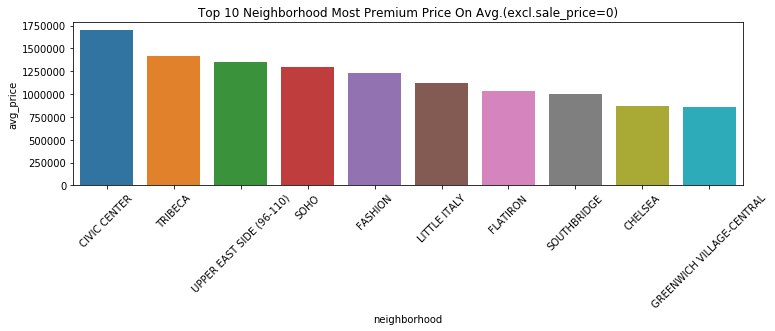

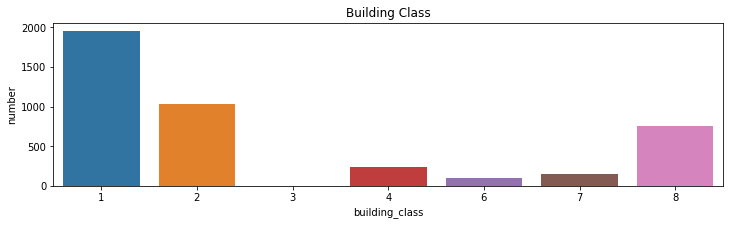

In [13]:
plt.figure(figsize=(12,3))
plt.xticks(rotation=45)
sns.barplot(x=top10_expensive_df.neighborhood,y=top10_expensive_df.avg_price).set(title='Top 10 Neighborhood Most Premium Price On Avg.(excl.sale_price=0)')
plt.figure(1).show()
plt.figure(figsize=(12,3))
sns.barplot(x=bclass.building_class,y=bclass.number).set(title='Building Class')
plt.figure(2).show()

- Most premium property neighborhoods are CivicCenter,Tribeca,UpperEastSide,Soho,Fashion and LittleItaly. Their most common building type is elevator apartments. 

### Market Analysis

In [15]:
## Building_Class Label Mapping: 
# '13  CONDOS - ELEVATOR APARTMENTS':1,
#  '10  COOPS - ELEVATOR APARTMENTS':2,'25  LUXURY HOTELS':3,
#  '17  CONDOPS':4,'07  RENTALS - WALKUP APARTMENT':5,
# '28  COMMERCIAL CONDOS':6,'09  COOPS - WALKUP APARTMENTS':7, 'THE REST': 8 
bclass_num=pd.DataFrame({'building_class':df.building_class_category.value_counts().index,'number':df.building_class_category.value_counts().values})
bclass_year=df[['building_class_category','year_built']]

[Text(0.5, 1.0, 'Building Class Sale Price (log) Boxplot')]

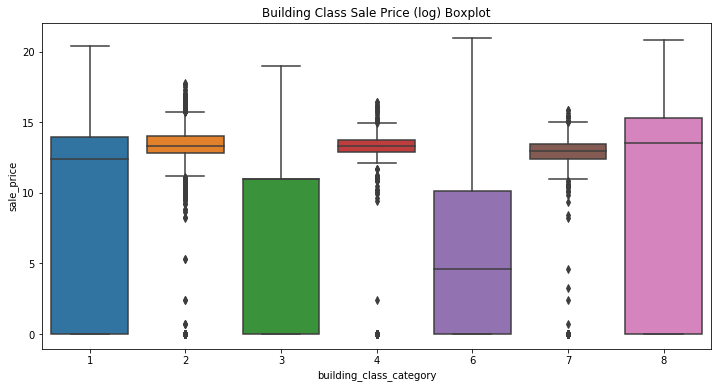

In [18]:
## Building Class Price Range
plt.figure(figsize=(12,6))
sns.boxplot(df.building_class_category,np.log1p(df.sale_price)).set(title='Building Class Sale Price (log) Boxplot')


[Text(0.5, 1.0, 'Property Quantity by Building Class ')]

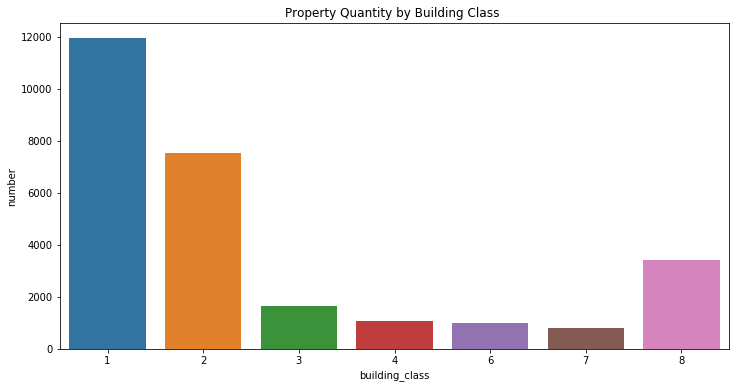

In [17]:
plt.figure(figsize=(12,6))
sns.barplot(bclass_num.building_class,bclass_num.number).set(title='Property Quantity by Building Class ')

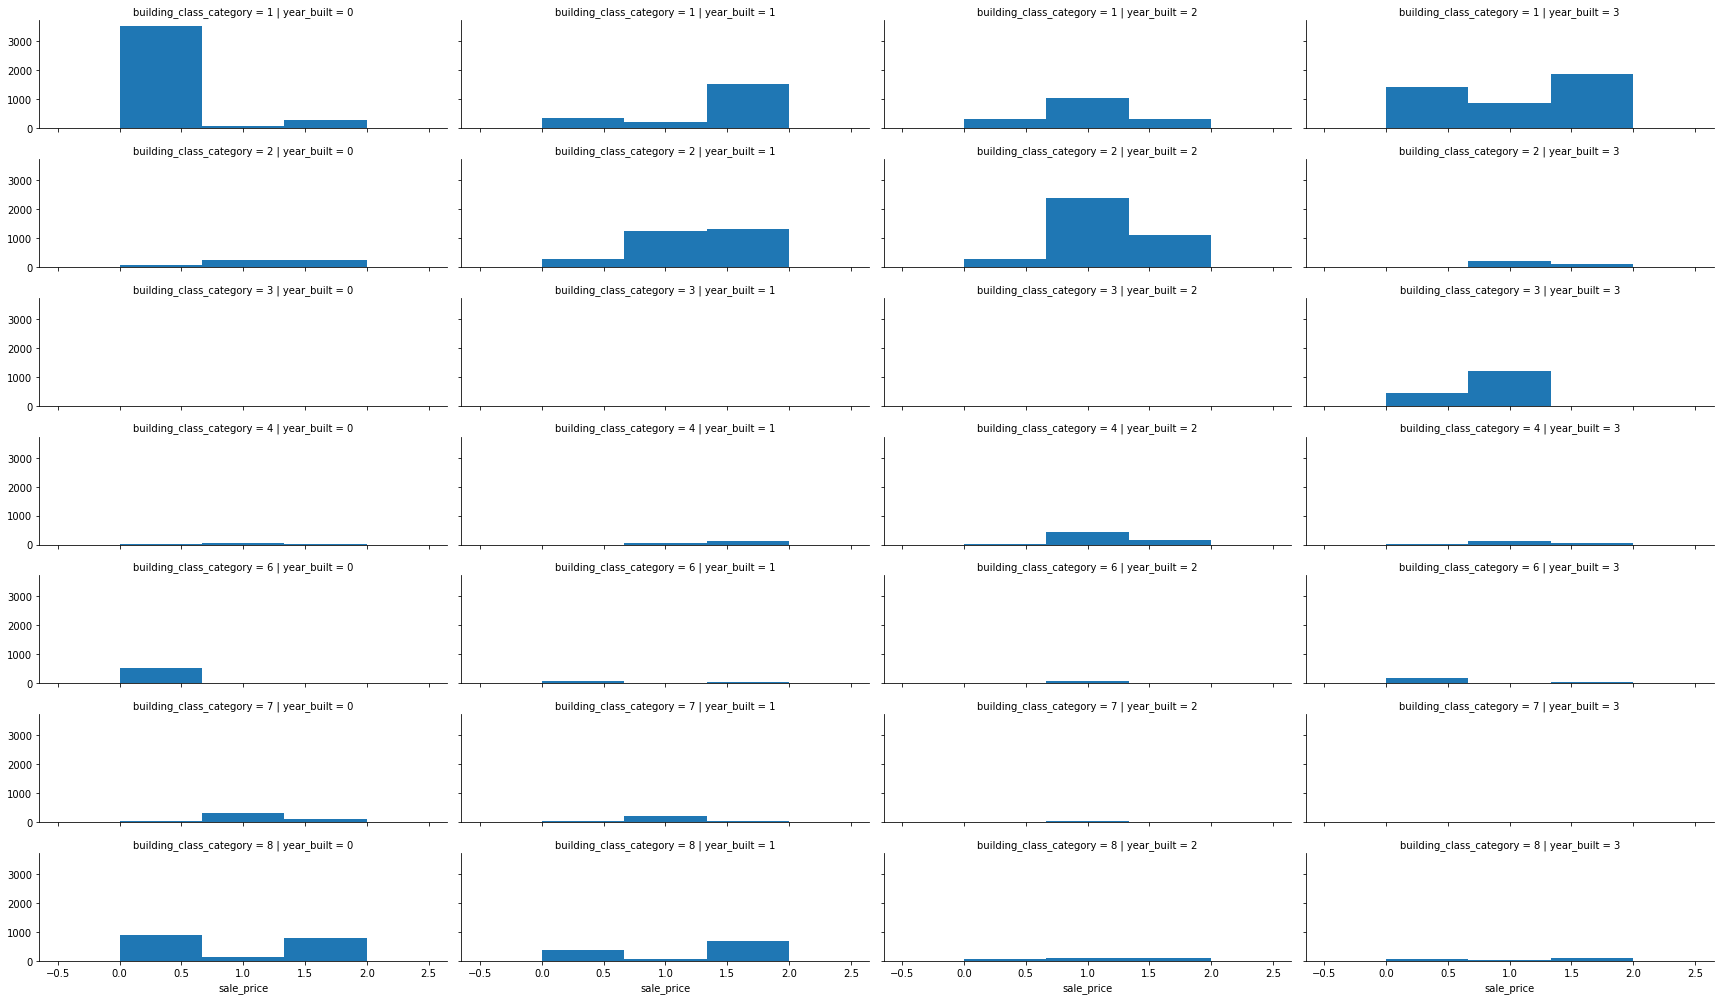

In [119]:
## Sale_Price in terms of Year_Built, Building_Class 
g=sns.FacetGrid(df_new,col='year_built',row='building_class_category',aspect=3,height=2)
g.map(plt.hist,'sale_price',bins=3)

- Current market is dominated by 13CondosElevatorApartments which is a well-established market (higher entry barrier) with long histories & mass amount of buildings & high profitability and 10CoopsElevatorApartments market with strong growth potential in premium price range & new construction opportunities.Commercial properties & hotels are relatively newly built and have less profitability compared to residential market.There is also an emerging market space for more niche & high profitability properties,such as Rentals-ElevatorApartments,Condos-2-10UnitResidential and One-TwoFamilyHomes. 
- Investors should focus on market with relatively lower entry barrier and less saturated competition such as 10CoopsElevatorApartments and smaller niche market (rentals,small family houses etc.)

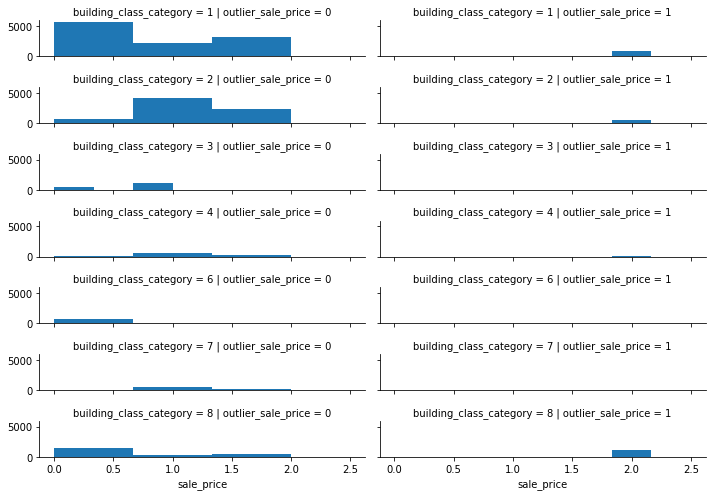

In [348]:
## Sale_Price in terms of outlier_sale_price and building_class_category
g=sns.FacetGrid(df_new,col='outlier_sale_price',row='building_class_category',aspect=5,height=1)
g.map(plt.hist,'sale_price',bins=3)

- Property type: elevator apartments is the most expensive building class type higher chance of exrtreme property price. 

In [19]:
year_sale_price=df[['sale_date','sale_price']].sort_values(by=['sale_date'])
year_sale_price=year_sale_price.reset_index(drop=True)

[Text(0.5, 1.0, 'Sale Price Over Time')]

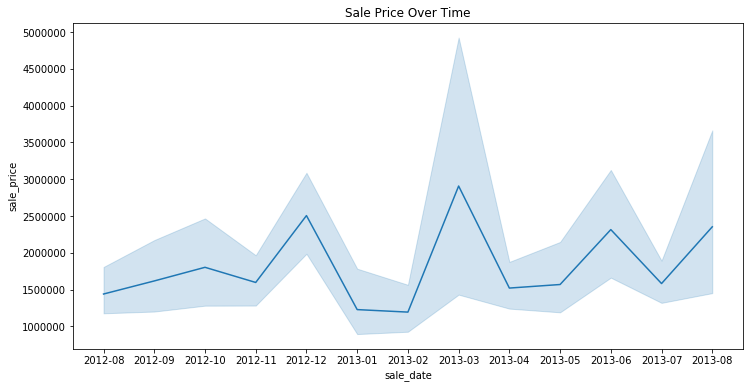

In [21]:
plt.figure(figsize=(12,6))
sns.lineplot(year_sale_price.sale_date,year_sale_price.sale_price).set(title='Sale Price Over Time')


[Text(0.5, 1.0, 'Sale Price(log) Over Time')]

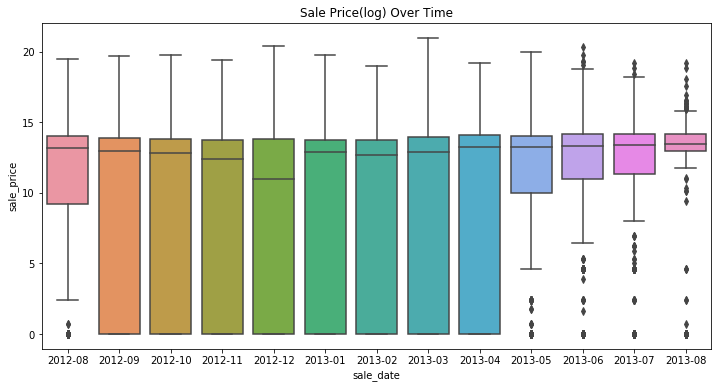

In [20]:
plt.figure(figsize=(12,6)) 
sns.boxplot(year_sale_price.sale_date,np.log1p(year_sale_price.sale_price)).set(title='Sale Price(log) Over Time')

Text(0.5, 1.0, 'Sale Quantity Over Time')

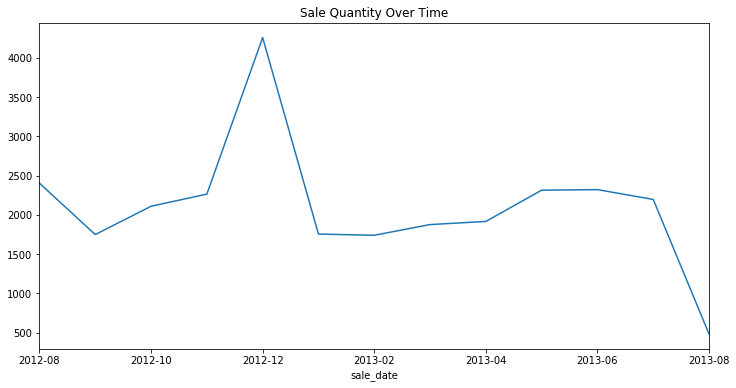

In [22]:
plt.figure(figsize=(12,6)) 
df.groupby(df.sale_date).count()['sale_price'].plot()
plt.title('Sale Quantity Over Time')

- Over time, total market sales fluctuated and hit multiple peaks at 2012-12 & 2013-03 and followed a general upward trends afterwards. 2013-03 topped the list with the most amount of premium properties sold and 2012-12 outperformed in quantity with 4258 properties sold. Since 2013, the market focused more on quality with much more premium properties and shrank in terms of quantity. In terms of seasonality, it looks like the market took off during Christmas period and spring and started to slow down in summer.   

## Modelling
- Logistic Regression To Classify Outlier SalePrice
- KMeans

### Logistic Regression To Classify Outlier SalePrice 

In [194]:
logR=LogisticRegression()
logR.fit(train,y_logistic)
coefs=pd.Series(logR.coef_[0],train.columns)
img=pd.concat([coefs.sort_values().head(5),coefs.sort_values().tail(5)])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Text(0.5, 1.0, 'Feature Importance')

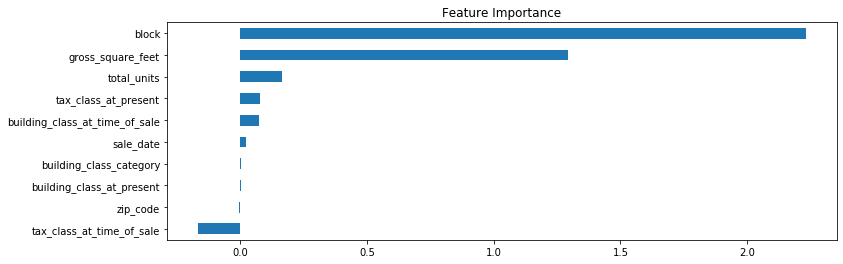

In [216]:
f,ax=plt.subplots(figsize=(12,4))
img.plot(kind='barh')
plt.title('Feature Importance')

- According to coefs result, block, gross_square_feet are most positively correlated to the default class (sale_price being outliers). As gross_square_feet increases and block moves towards block 2710 or outside block 1009 & 1006, the probability of sale price being outlier increases the most. 

### KMeans Clustering

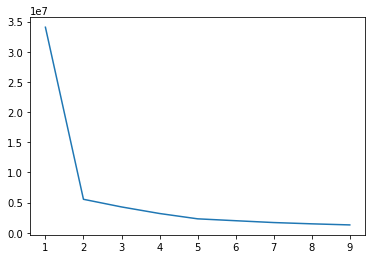

In [236]:
## According to elbow curve, optimal k value should be between [2,5], so we choose 4
km=KMeans(n_clusters=8)
km.fit(train)
error=[]
for i in range(1,10):
    km=KMeans(n_clusters=i)
    km.fit(train)
    error.append(km.inertia_)
plt.plot(range(1,10),error)

In [238]:
km=KMeans(n_clusters=4)
km.fit(train)
y_pred=km.predict(train)
kmeans=pd.DataFrame(y_pred)
labels=km.labels_
train.insert((train.shape[1]),'kmeans',kmeans)
df_new['bclass_present_code']=le.fit_transform(df_new['building_class_at_present'])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Text(0, 0.5, 'zip_code')

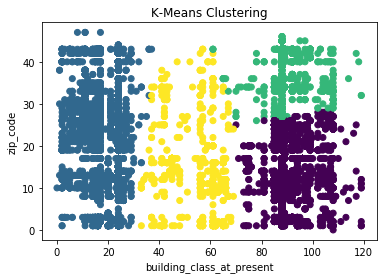

In [317]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.scatter(train['building_class_at_present'],train['zip_code'],c=labels)
ax.set_title('K-Means Clustering')
ax.set_xlabel('building_class_at_present')
ax.set_ylabel('zip_code')

- According to KMeans, the dataset could be split into 4 groups by 'building_class_at_present' & 'zip_code': BuildingClass R with ZipCode 10028 onwards,BuildingClass R with ZipCode below 10028, BuildingClass H, BuildingClass D & C. This could be useful to segment property market based on their present building class & zipcode to tailor pricing strategy and forecast demand & supply etc.

## Executive Summary

- Top 10 neighborhoods are Midtown,UpperSide,Chelsea etc. MidtownWest is the most dominant commercial area with 64% of not for sale properties(SalePrice=0),LuxuryHotels(the only area), largest amount of Condos-ElevatorApartments and the largest amount of old buildings. UpperSide generally has more modern buildings with middle upper price range despite large amount of not for sale properties.Chelsea is mixed with 2nd largest old buildings and new residential apartments. 

- Current market is dominated by 13CondosElevatorApartments which is a well-established market (higher entry barrier) with long histories & mass amount of buildings & high profitability and 10CoopsElevatorApartments market with strong growth potential in premium price range & new building construction opportunities.Commercial properties and hotels are relatively newly built and have less profitability. Meanwhile there is an emerging market space for more niche & high profitability properties,such as Rentals-ElevatorApartments,Condos-2-10UnitResidential and One-TwoFamilyHomes.

- Over time, total market sales fluctuated and hit peaks at 2012-12 & 2013-03 and followed an upward trends afterwards. During 2013-03 the market sold the most amount of premium properties and during 2012-12 the market outperformed in quantity with 4258 properties sold. Since 2013, the market focused more on quality with more premium properties and shrank in quantity size. For seasonality,the market took off during Christmas period & spring and started to slow down in summer.
- According to KMeans, the market could be clustered into 4 groups by BuildingClassAtPresent & ZipCode: BuildingClass R with ZipCode 10028 onwards,BuildingClass R with ZipCode below 10028, BuildingClass H, BuildingClass D & C.

## Action Plan 

- Companies should focus on the market with relatively lower entry barrier and less saturated competition such as 10CoopsElevatorApartments and smaller niche market (rentals,small family houses etc.)
- Seasonality: peak season is from Christmas to Spring and summer is off-peak, buyers and sellers could adjust their strategies based on the shifting demand & supply.
- Segmentation: the market could be segmented based on present building class & zipcode to tailor to different pricing strategy etc.

# Thank you